
# Demo 4 — Monitoring Model Drift with Alerts and Rollbacks (Teaching Notebook)

**Goal:** Practice simulating data drift, detecting it statistically, triggering simple alerts, visualizing the change, rolling back to a stable model when drift is detected, and exporting a drift report.

> This notebook is structured for teaching. Every step includes explanation first, then runnable code.


In [1]:
# Task 1: Set up environment and dependencies
# (If running on a managed environment, you may not need to pip install.)
# Remove the leading "!" if your environment requires a different installer step.
import sys

try:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_classification
    from scipy.stats import ks_2samp
except ImportError:
    !pip install pandas scikit-learn matplotlib seaborn scipy -q
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_classification
    from scipy.stats import ks_2samp

# Display versions for reproducibility
import importlib, platform
print("Python:", platform.python_version())
for m in ["pandas","numpy","matplotlib","seaborn","scipy","sklearn"]:
    mod = importlib.import_module(m)
    print(f"{m}: {getattr(mod, '__version__', 'n/a')}")


Python: 3.12.12
pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
seaborn: 0.13.2
scipy: 1.16.2
sklearn: 1.6.1



Drift Detection Report (KS two-sample test)
------------------------------------------------
[ALERT] feature_0  | p-value = 0.0000
[ALERT] feature_1  | p-value = 0.0000
[ALERT] feature_2  | p-value = 0.0000
[ALERT] feature_3  | p-value = 0.0428
[ALERT] feature_4  | p-value = 0.0000

✅ KS-test complete


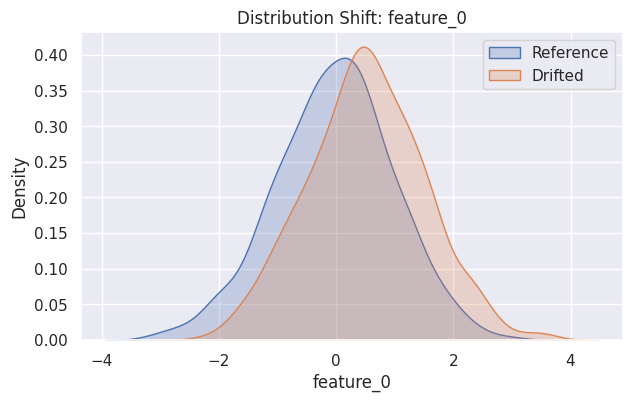

In [9]:
# Task 2: Simulate data drift (Teaching notes)

# Create a "reference" dataset (stable period)
X_ref, _ = make_classification(
    n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
    random_state=42, shift=0.0
)
df_ref = pd.DataFrame(X_ref, columns=[f"feature_{i}" for i in range(5)])

# Create a "drifted" dataset (later period with shifted distribution)
X_drifted, _ = make_classification(
    n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
    random_state=55, shift=0.5
)
df_drifted = pd.DataFrame(X_drifted, columns=df_ref.columns)


# Task 3: Detect drift using the Kolmogorov–Smirnov (KS) test
alpha = 0.05  # significance level
drift_report = {}

print("\nDrift Detection Report (KS two-sample test)\n" + "-"*48)
for feature in df_ref.columns:
    stat, p_value = ks_2samp(df_ref[feature], df_drifted[feature])
    drift_detected = bool(p_value < alpha)
    drift_report[feature] = {"p_value": float(p_value), "drift_detected": drift_detected}
    status = "[ALERT]" if drift_detected else "[OK]   "
    print(f"{status} {feature:<10} | p-value = {p_value:.4f}")

print("\n✅ KS-test complete")
# Task 4: Visualize drift (KDE of first drifted feature)
sns.set_theme()
drifted_feature = next((f for f, v in drift_report.items() if v["drift_detected"]), None)

if drifted_feature is not None:
    fig = plt.figure(figsize=(7,4))
    sns.kdeplot(df_ref[drifted_feature], label="Reference", fill=True)
    sns.kdeplot(df_drifted[drifted_feature], label="Drifted", fill=True)
    plt.title(f"Distribution Shift: {drifted_feature}")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No drifted feature found at p<0.05; nothing to visualize.")

In [10]:
# Task 5: Simulate rollback mechanism
models = {"stable": "model_v1.pkl", "current": "model_v2.pkl"}

if any(v["drift_detected"] for v in drift_report.values()):
    print("\nDrift detected. Rolling back to:", models["stable"])
    selected_model = models["stable"]
else:
    print("\nNo drift detected. Using:", models["current"])
    selected_model = models["current"]

selected_model



Drift detected. Rolling back to: model_v1.pkl


'model_v1.pkl'


## Task 1 — Set up environment and dependencies (Teaching notes)

We'll use the following libraries:
- **pandas / numpy** for data handling
- **scikit-learn** to generate synthetic data
- **scipy** for the Kolmogorov–Smirnov (KS) two-sample test
- **matplotlib** to visualize distribution shifts

> In hosted environments (e.g., Google Colab), the `pip` cell below ensures required packages are present.


In [11]:

# If you're in Colab (or a fresh environment), uncomment the next lines to install dependencies.
# %pip install --quiet pandas numpy scikit-learn scipy matplotlib
print("✅ Environment cell ready. Install lines are commented for portability.")


✅ Environment cell ready. Install lines are commented for portability.



### Imports

We import everything we need up front for clarity.


In [12]:

import json
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Set a style and larger default figure size for readability in class
plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})
print("✅ Libraries imported")


✅ Libraries imported



## Task 2 — Simulate data drift (Teaching notes)

We'll generate two batches of data with **the same columns but different distributions**:
- **Reference batch** (represents a stable production period).
- **Current/Drifted batch** (represents a later period where the distribution may have shifted).

We'll use `sklearn.datasets.make_classification` twice with different random seeds and a **shift** to simulate covariate drift.


In [13]:

# Create a "reference" dataset (stable period)
X_ref, _ = make_classification(
    n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
    random_state=42, shift=0.0
)
df_ref = pd.DataFrame(X_ref, columns=[f"feature_{i}" for i in range(5)])

# Create a "drifted" dataset (later period with shifted distribution)
X_drifted, _ = make_classification(
    n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
    random_state=55, shift=0.5
)
df_drifted = pd.DataFrame(X_drifted, columns=df_ref.columns)

print("✅ Simulated reference and drifted datasets created")
df_ref.head()


✅ Simulated reference and drifted datasets created


,feature_0,feature_1,feature_2,feature_3,feature_4
0,-0.529332,-0.093387,-1.526572,0.406847,-0.619699
1,-0.978500,-1.690672,1.229308,-0.703071,0.202055
2,-2.171571,0.545787,1.253433,1.527726,1.780785
3,-0.151299,-0.365506,1.335714,0.038355,-0.005317
4,-0.777371,1.146030,-2.479343,0.297014,1.518522



## Task 3 — Detect drift using the Kolmogorov–Smirnov (KS) test (Teaching notes)

**What is the KS test?**  
A non-parametric test that compares two distributions.  
- **Null hypothesis**: both samples come from the same distribution.  
- If the **p-value < 0.05**, we reject the null → we consider **drift detected** for that feature.

We'll compute the test **per feature** and build a `drift_report` with p-values and boolean flags.


In [14]:

alpha = 0.05  # significance level
drift_report = {}

print("\nDrift Detection Report (KS two-sample test)\n" + "-"*48)
for feature in df_ref.columns:
    stat, p_value = ks_2samp(df_ref[feature], df_drifted[feature])
    drift_detected = bool(p_value < alpha)
    drift_report[feature] = {"p_value": float(p_value), "drift_detected": drift_detected}
    status = "[ALERT]" if drift_detected else "[OK]   "
    print(f"{status} {feature:<10} | p-value = {p_value:.4f}")

print("\n✅ KS-test complete")
drift_report



Drift Detection Report (KS two-sample test)
------------------------------------------------
[ALERT] feature_0  | p-value = 0.0000
[ALERT] feature_1  | p-value = 0.0000
[ALERT] feature_2  | p-value = 0.0000
[ALERT] feature_3  | p-value = 0.0428
[ALERT] feature_4  | p-value = 0.0000

✅ KS-test complete


{'feature_0': {'p_value': 2.0545862271954644e-21, 'drift_detected': True},
 'feature_1': {'p_value': 4.148242783943996e-30, 'drift_detected': True},
 'feature_2': {'p_value': 1.4811534595157654e-17, 'drift_detected': True},
 'feature_3': {'p_value': 0.042792013924212634, 'drift_detected': True},
 'feature_4': {'p_value': 1.5818384838992494e-101, 'drift_detected': True}}


## Task 4 — Visualize drift (Teaching notes)

We will visualize the **first feature** that shows drift, if any.  
To keep dependencies minimal and teaching-friendly, we'll use **matplotlib** with overlaid histograms and smoothed density curves (via `gaussian_kde` if available).

> Tip: In production, prefer consistent binning and fixed axes limits across time windows to make visual comparison easier.


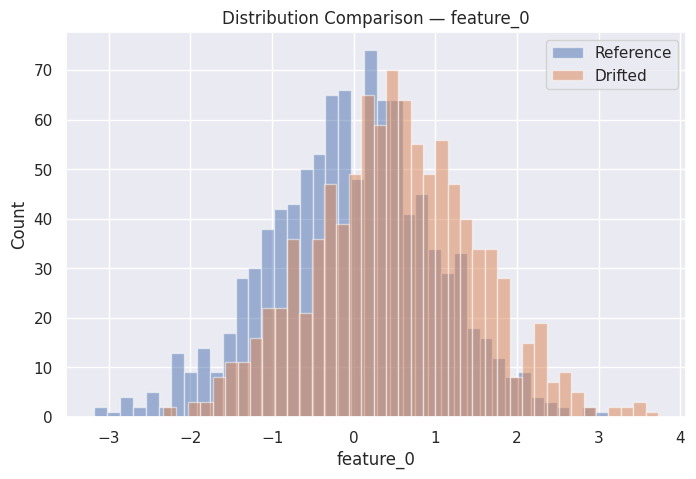

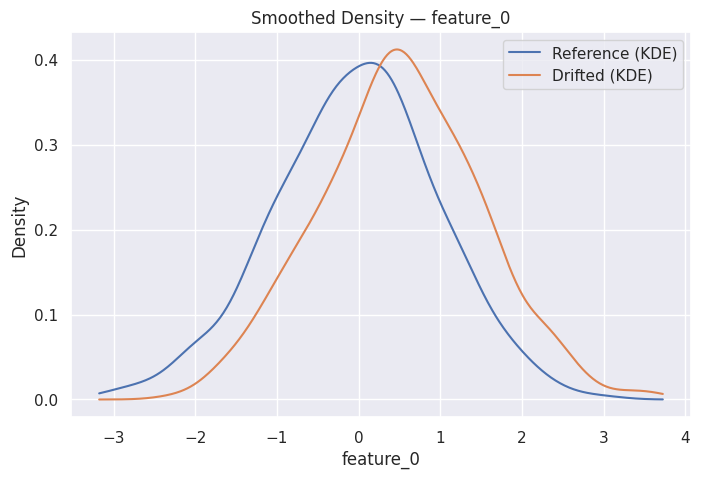

In [15]:

# Find the first feature with detected drift
drifted_feature = next((f for f, v in drift_report.items() if v["drift_detected"]), None)

if drifted_feature is None:
    print("No individual feature crossed the drift threshold. Showing feature_0 anyway for illustration.")
    drifted_feature = "feature_0"

# Plot overlaid histograms
fig = plt.figure()
plt.hist(df_ref[drifted_feature], bins=40, alpha=0.5, label="Reference")
plt.hist(df_drifted[drifted_feature], bins=40, alpha=0.5, label="Drifted")
plt.title(f"Distribution Comparison — {drifted_feature}")
plt.xlabel(drifted_feature)
plt.ylabel("Count")
plt.legend()
plt.show()

# Optional: Smoothed densities if scipy is available
try:
    from scipy.stats import gaussian_kde
    x1 = df_ref[drifted_feature].values
    x2 = df_drifted[drifted_feature].values
    xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 500)

    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)

    plt.figure()
    plt.plot(xs, kde1(xs), label="Reference (KDE)")
    plt.plot(xs, kde2(xs), label="Drifted (KDE)")
    plt.title(f"Smoothed Density — {drifted_feature}")
    plt.xlabel(drifted_feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()
except Exception as e:
    print("KDE plot skipped:", e)



## Task 5 — Simulate a rollback mechanism (Teaching notes)

A simple policy:  
- If **any** feature indicates drift (p-value < 0.05), **roll back** to the known-stable model.  
- Otherwise, keep using the current model.

> In production, you would integrate this with your **model registry**, **feature store**, and **CI/CD** to atomically switch versions and log an audit trail.


In [17]:

# Simulated "model registry" choices
models = {"stable": "model_v1.pkl", "current": "model_v2.pkl"}

if any(v["drift_detected"] for v in drift_report.values()):
    chosen_model = models["stable"]
    print("\n⚠️ Drift detected. Rolling back to:", chosen_model)
else:
    chosen_model = models["current"]
    print("\n✅ No drift detected. Using:", chosen_model)



⚠️ Drift detected. Rolling back to: model_v1.pkl



## Task 6 — Export drift detection report (Teaching notes)

We export a JSON artifact that includes:
- Timestamp
- Selected model
- Per-feature p-values and drift flags

> This file can feed dashboards, alerts, and long-term monitoring/forensics.


In [18]:

drift_summary = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "alpha": 0.05,
    "model_used": chosen_model,
    "drift_report": drift_report
}

output_path = "drift_detection_report.json"
with open(output_path, "w") as f:
    json.dump(drift_summary, f, indent=2)

print(f"✅ Drift report saved to {output_path}")


✅ Drift report saved to drift_detection_report.json


/tmp/ipython-input-25300746.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",



### Bonus — Quick peek at the saved JSON (Teaching notes)


In [19]:

with open("drift_detection_report.json", "r") as f:
    content = json.load(f)
content


{'generated_at': '2025-10-25T16:51:17.935823Z',
 'alpha': 0.05,
 'model_used': 'model_v1.pkl',
 'drift_report': {'feature_0': {'p_value': 2.0545862271954644e-21,
   'drift_detected': True},
  'feature_1': {'p_value': 4.148242783943996e-30, 'drift_detected': True},
  'feature_2': {'p_value': 1.4811534595157654e-17, 'drift_detected': True},
  'feature_3': {'p_value': 0.042792013924212634, 'drift_detected': True},
  'feature_4': {'p_value': 1.5818384838992494e-101, 'drift_detected': True}}}


## Wrap-up (Teaching notes)

In this lab you:
1. Generated reference and drifted datasets.
2. Ran a **KS two-sample test** per feature.
3. Flagged drift and printed simple alerts.
4. Visualized a drifted feature's distribution.
5. Applied a simple **rollback** policy when drift was detected.
6. Exported a **JSON** drift report suitable for monitoring and audit trails.

> Next steps: integrate with a production monitoring stack (e.g., MLFlow, Evidently AI, Prometheus/Grafana, or cloud-native MLOps) and add **data-quality** and **label** drift checks.
